In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, average
from keras import backend as K
from keras.utils import to_categorical, plot_model
#from deeplift.visualization import viz_sequence
import shap
from IPython.display import Image
from IPython.core.display import HTML 
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature, transform
import sys
import optparse
import tensorflow
from array import *
import sklearn
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import RMSprop
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.layers import Concatenate
from keras.callbacks import ModelCheckpoint


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 height_padding_factor,
                 length_padding,
                 subticks_frequency,
                 highlight,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    return ax


def plot_weights(array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    #fig.savefig('/staging/leuven/stg_00002/lcb/itask/deep_learning/deep_lift/test.png')
    plt.show()

def plot_weights_noshow(array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    fig = plt.figure(figsize=figsize) 
    ax = fig.add_subplot(111) 
    y = plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    #fig.savefig('/staging/leuven/stg_00002/lcb/itask/deep_learning/deep_lift/test.png')
    return y,fig

def plot_weights_noshow2(array, fig, n, title='',
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=20,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    #fig = plt.figure(figsize=figsize) 
    ax = fig.add_subplot(n) 
    ax.set_title(title)
    y = plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    #fig.savefig('/staging/leuven/stg_00002/lcb/itask/deep_learning/deep_lift/test.png')
    return fig

def plot_weights_noshow2_ylab(array, fig, n, title='', ylab='',
                              figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=20,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    #fig = plt.figure(figsize=figsize) 
    ax = fig.add_subplot(n) 
    ax.set_title(title)
    ax.set_ylabel(ylab)
    y = plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    #fig.savefig('/staging/leuven/stg_00002/lcb/itask/deep_learning/deep_lift/test.png')
    return fig

def plot_weights_noshow2_ylab_2(array, fig, n,n1,n2, title='', ylab='',
                              figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=20,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    #fig = plt.figure(figsize=figsize) 
    ax = fig.add_subplot(n,n1,n2) 
    ax.set_title(title)
    ax.set_ylabel(ylab)
    y = plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    #fig.savefig('/staging/leuven/stg_00002/lcb/itask/deep_learning/deep_lift/test.png')
    return fig,ax

def plot_weights_noshow3(array, fig, x, y, z, title='',
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=20,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    #fig = plt.figure(figsize=figsize) 
    ax = fig.add_subplot(x,y,z) 
    ax.set_title(title)
    y = plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    #fig.savefig('/staging/leuven/stg_00002/lcb/itask/deep_learning/deep_lift/test.png')
    return fig

def plot_weights_noshow3_noaxes(array, fig, x, y, z, title='',
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=20,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    #fig = plt.figure(figsize=figsize) 
    ax = fig.add_subplot(x,y,z) 
    ax.set_title(title)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    y = plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    #fig.savefig('/staging/leuven/stg_00002/lcb/itask/deep_learning/deep_lift/test.png')
    return fig


def json_hdf5_to_model(json_filename, hdf5_filename):  
    with open(json_filename, 'r') as f:
        model = model_from_json(f.read())
    model.load_weights(hdf5_filename)
    return model
    
def readfile(filename):
    ids = []
    ids_d = {}
    seqs = {}
    classes = {}
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()
    seq = []
    for line in lines:
        if line[0] == '>':
            ids.append(line[1:].rstrip('\n'))
            if line[1:].rstrip('\n').split('_')[0] not in seqs:
                seqs[line[1:].rstrip('\n').split('_')[0]] = []
            if line[1:].rstrip('\n').split('_')[0] not in ids_d:
                ids_d[line[1:].rstrip('\n').split('_')[0]] = line[1:].rstrip('\n').split('_')[0]
            if line[1:].rstrip('\n').split('_')[0] not in classes:
                classes[line[1:].rstrip('\n').split('_')[0]] = np.zeros(NUM_CLASSES)
            
            classes[line[1:].rstrip('\n').split('_')[0]][int(line[1:].rstrip('\n').split('_')[1])-1] = 1        
            if seq != []: seqs[ids[-2].split('_')[0]]= ("".join(seq))
            seq = []
        else:
            seq.append(line.rstrip('\n').upper())
    if seq != []:
        seqs[ids[-1].split('_')[0]]=("".join(seq))

    return ids,ids_d,seqs,classes

def readfile_wolabel(filename):
    ids = []
    ids_d = {}
    seqs = {}
    classes = {}
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()
    seq = []
    for line in lines:
        if line[0] == '>':
            ids.append(line[1:].rstrip('\n'))
            if line[1:].rstrip('\n') not in seqs:
                seqs[line[1:].rstrip('\n')] = []
            if line[1:].rstrip('\n') not in ids_d:
                ids_d[line[1:].rstrip('\n')] = line[1:].rstrip('\n')    
            if seq != []: seqs[ids[-2]]= ("".join(seq))
            seq = []
        else:
            seq.append(line.rstrip('\n').upper())
    if seq != []:
        seqs[ids[-1]]=("".join(seq))

    return ids,ids_d,seqs,classes


def one_hot_encode_along_row_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((1,len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return[0],
                                 sequence=sequence, one_hot_axis=1)
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #zeros_array should be an array of dim 4xlen(sequence), filled with zeros.
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
def path_to_X_id_dict(path):
    filename = path
    ids, ids_d, seqs, classes = readfile_wolabel(filename)
    X = np.array([one_hot_encode_along_row_axis(seqs[id]) for id in ids_d]).squeeze(axis=1)
    X_rc = [X,  X[:,::-1,::-1]]
    result = {'ids':ids, 'ids_d':ids_d, 'seqs':seqs, 'classes':classes, 'X':X, 'X_rc':X_rc }
    return result

def path_to_X_id_dict_withUPDOWN(path,up,down):
    filename = path
    ids, ids_d, seqs, classes = readfile_wolabel(filename)
    X = np.array([one_hot_encode_along_row_axis(up+seqs[id]+down) for id in ids_d]).squeeze(axis=1)
    X_rc = [X,  X[:,::-1,::-1]]
    result = {'ids':ids, 'ids_d':ids_d, 'seqs':seqs, 'classes':classes, 'X':X, 'X_rc':X_rc }
    return result

def path_to_id_dict(path):
    filename = path
    ids, ids_d, seqs, classes = readfile_wolabel(filename)
    result = {'ids':ids, 'ids_d':ids_d, 'seqs':seqs, 'classes':classes, }
    return result

def path_to_X_id_dict_label(path):
    train_filename = path   
    train_ids,train_ids_d, train_seqs, train_classes = readfile(train_filename)
    X = np.array([one_hot_encode_along_row_axis(train_seqs[id]) for id in train_ids_d]).squeeze(axis=1)
    y = np.array([train_classes[id] for id in train_ids_d])

    y = y[:,selected_classes]
    X = X[y.sum(axis=1)>0]
    ids = np.array([id for id in train_ids_d])
    ids = ids[y.sum(axis=1)>0]
    y = y[y.sum(axis=1)>0]
    X_rc = [X,  X[:,::-1,::-1]]
    
    X_single=X[y.sum(axis=1)==1]
    y_single=y[y.sum(axis=1)==1]
    ids_single=ids[y.sum(axis=1)==1]
    
    result = {'ids':train_ids, 'ids_d':train_ids_d, 'seqs':train_seqs, 'classes':train_classes, 'X':X, 'X_rc':X_rc, 'y':y ,"y_single":y_single}
    return result   

def loc_to_model(loc):
    return json_hdf5_to_model(loc + 'model.json', loc + 'model_best_loss.hdf5')
def loc_to_model_loss(loc):
    return json_hdf5_to_model(loc + 'model.json', loc + 'model_best_loss.hdf5')
def loc_to_model_acc(loc):
    return json_hdf5_to_model(loc + 'model.json', loc + 'model_best_acc.hdf5')

def readnpzdict(loc):
    X=np.load(loc)['X']
    Y=np.load(loc)['Y']
    Z={}
    for i in range(len(Y)):
        Z[Y[i]]=X[i]
    return Z
def readoccdict(loc):
    X=np.load(loc)['X']
    Y=np.load(loc)['Y']
    Z=np.load(loc)['Z']
    return X,Y,Z
def readmotifdict(loc):
    Y=np.load(loc)['Y'].item()
    return Y
def readallatacacdict(loc):
    tett = np.load(loc)['X'][()]
    allatacac_dict = {}
    for i in range(len(ids)):
        allatacac_dict[ids[i]]={}
        for names in tett:
            allatacac_dict[ids[i]][names]=tett[names][0][i]
    return allatacac_dict

def path_to_X_id_dict(path):
    filename = path
    ids, ids_d, seqs, classes = readfile_wolabel(filename)
    X = np.array([one_hot_encode_along_row_axis(seqs[id]) for id in ids_d]).squeeze(axis=1)
    X_rc = [X,  X[:,::-1,::-1]]
    result = {'ids':ids, 'ids_d':ids_d, 'seqs':seqs, 'classes':classes, 'X':X, 'X_rc':X_rc }
    return result

def readallatacacdict__(loc,ids):
    tett = np.load(loc)['X'][()]
    allatacac_dict = {}
    for i in range(len(ids)):
        allatacac_dict[ids[i]]={}
        for names in tett:
            allatacac_dict[ids[i]][names]=tett[names][0][i]
    return allatacac_dict

import string
from random import *
def path_to_X_id_dict_withUPDOWN(path,up,down,barcode_loc):
    filename = path
    ids, ids_d, seqs, classes = readfile_wolabel(filename)
    barcode=[]
    for i in range(len(ids)):
        password = "".join(choice("ACTG") for x in range(17))
        barcode.append(password)
    barcode = np.array(barcode)
    X = np.array([one_hot_encode_along_row_axis(up+seqs[id][20:210]+down[:barcode_loc]+barcode[i]+down[barcode_loc+17:]) for i,id in enumerate(ids_d)]).squeeze(axis=1)
    #print(up,down[:barcode_loc],barcode[0],down[barcode_loc+17:])
    X_rc = [X,  X[:,::-1,::-1]]
    result = {'ids':ids, 'ids_d':ids_d, 'seqs':seqs, 'classes':classes, 'X':X, 'X_rc':X_rc }
    return result

def generate_samples(gen_imgs):
    char_ACGT={0:'A' , 1:'C' , 2:'G' , 3:'T'}
    samples = np.argmax(gen_imgs, axis=1)
    decoded_samples = []
    #for i in range(len(samples)):
    decoded = ''
    for j in range(len(samples)):
        decoded+= char_ACGT[samples[j]]
        
    return decoded

def deepexplainer_plot(name, OLS, topic, model, save="False"):
    if model=="deepmel":
        selected_classes=np.array(list(range(24)))
    if model=="deepmel2":
        selected_classes=np.array(list(range(47)))
    if model=="deepmel2_gabpa":
        selected_classes=np.array(list(range(48)))
    
    name__ = name
    topic_ = str(topic-1)
    shap_values_,indexes_ = e_dict[model].shap_values([OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__],
                                            OLS_dict[OLS]["X_rc"][1][np.array(OLS_dict[OLS]["ids"])==name__]],
                                            output_rank_order=topic_,ranked_outputs=1)
    print("Topic: " + str(indexes_[0][0]+1))
    ntrack=5
    fig = plt.figure(figsize=(80,25))
    _, ax1 =plot_weights_noshow2_ylab_2(shap_values_[0][0][0]*OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__],fig,ntrack,1,1,title=name__, subticks_frequency=10,ylab="FORWARD\nDeepExplainer")
    _, ax2 =plot_weights_noshow2_ylab_2((shap_values_[0][1][0]*OLS_dict[OLS]["X_rc"][1][np.array(OLS_dict[OLS]["ids"])==name__])[0][::-1,:],fig,ntrack,1,2,subticks_frequency=10,ylab="REVERSE\nDeepExplainer")
    ax1.set_ylim([np.min([ax1.get_ylim()[0],ax2.get_ylim()[0] ]) , np.max([ax1.get_ylim()[1],ax2.get_ylim()[1] ])])
    ax2.set_ylim([np.min([ax1.get_ylim()[0],ax2.get_ylim()[0] ]) , np.max([ax1.get_ylim()[1],ax2.get_ylim()[1] ])])
    ax1.axvline(x=155,color='gray')
    ax1.axvline(x=155+190,color='gray')
    ax2.axvline(x=155,color='gray')
    ax2.axvline(x=155+190,color='gray')
    arrr_A = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_C = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_G = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_T = np.zeros((len(selected_classes),seq_shape[0]))
    new_X = np.copy(OLS_dict[OLS]["X"][np.array(OLS_dict[OLS]["ids"])==name__])
    real_score=model_dict[model].predict([new_X,new_X[:,::-1,::-1]])[0]
    for mutloc in range(seq_shape[0]):     
        new_X_= np.copy(new_X)
        new_X_[0][mutloc,:] = np.array([1, 0, 0, 0], dtype='int8')
        arrr_A[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
        new_X_[0][mutloc,:] = np.array([0, 1, 0, 0], dtype='int8')
        arrr_C[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
        new_X_[0][mutloc,:] = np.array([0, 0, 1, 0], dtype='int8')
        arrr_G[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
        new_X_[0][mutloc,:] = np.array([0, 0, 0, 1], dtype='int8')
        arrr_T[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
    arrr_A[arrr_A==0]=None
    arrr_C[arrr_C==0]=None
    arrr_G[arrr_G==0]=None
    arrr_T[arrr_T==0]=None
    ax = fig.add_subplot(ntrack,1,3)
    ax.set_ylabel('IN-SILICO\nMPRA\n'+ topic_dict[indexes_[0][0]])
    ax.scatter(range(seq_shape[0]),-1*arrr_A[indexes_[0][0]],label='A',color='green')
    ax.scatter(range(seq_shape[0]),-1*arrr_C[indexes_[0][0]],label='C',color='blue')
    ax.scatter(range(seq_shape[0]),-1*arrr_G[indexes_[0][0]],label='G',color='orange')
    ax.scatter(range(seq_shape[0]),-1*arrr_T[indexes_[0][0]],label='T',color='red')
    ax.legend()
    ax.axhline(y=0,linestyle='--',color='gray')
    ax.set_xlim((0,seq_shape[0])) 
    _ = ax.set_xticks(np.arange(0, seq_shape[0]+1, 10))
    ax.axvline(x=155,color='gray')
    ax.axvline(x=155+190,color='gray')
#    if OLS!="500":
#        ax = fig.add_subplot(ntrack,1,4)
#        ax.plot(OLS_dict[OLS]["occ_w"][name__],"black",label="Nuc. MIDDLE")
#        ax2=ax.twinx()
#        ax2.plot(OLS_dict[OLS]["occ_p"][name__],"red",label="Nuc. START")
#        ax.margins(x=0)
#        ax.legend(loc="upper left")
#        ax2.legend(loc="upper right")
    ax = fig.add_subplot(ntrack,4,ntrack*4-3)
    ax.margins(x=0)
    ax.set_ylabel('PREDICTION')
    ax.plot(model_dict[model].predict([new_X,new_X[:,::-1,::-1]]).T,'--', color='gray',linewidth=3)
    ax.scatter(range(len(selected_classes)),model_dict[model].predict([new_X,new_X[:,::-1,::-1]]).T,marker='o', color='red',linewidth=8)
    ax.set_xticks(range(len(selected_classes)),) 
    ax.grid(True)
    _ = ax.set_xticklabels(np.array(list(range(1,len(selected_classes)+1))), rotation=90,)
    if save!="False":
        plt.savefig(save+"OLS-"+OLS+"_topic"+str(indexes_[0][0]+1)+"_"+name__+".pdf",dpi=600,transparent=True)
        plt.close()


        
def deepexplainer_plot_with_mutation(name, OLS, topic, model, mutation_list, save="False"):
    if model=="deepmel":
        selected_classes=np.array(list(range(24)))
    if model=="deepmel2":
        selected_classes=np.array(list(range(47)))
    if model=="deepmel2_gabpa":
        selected_classes=np.array(list(range(48)))
        
    nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}
    name__ = name
    topic_ = str(topic-1)
    mut_X = np.copy(OLS_dict[OLS]["X"][np.array(OLS_dict[OLS]["ids"])==name__])
    for mutloc, mutletter in mutation_list:
        mut_X[0][mutloc,:] = np.array(nuc_to_onehot[mutletter], dtype='int8')
        
    shap_values_,indexes_ = e_dict[model].shap_values([mut_X,mut_X[:,::-1,::-1]],
                                            output_rank_order=topic_,ranked_outputs=1)
    print("Topic: " + str(indexes_[0][0]+1))
    ntrack=5
    fig = plt.figure(figsize=(80,25))
    _, ax1 =plot_weights_noshow2_ylab_2(shap_values_[0][0][0]*mut_X,fig,ntrack,1,1,title=name__, subticks_frequency=10,ylab="FORWARD\nDeepExplainer")
    _, ax2 =plot_weights_noshow2_ylab_2((shap_values_[0][1][0]*mut_X[:,::-1,::-1])[0][::-1,:],fig,ntrack,1,2,subticks_frequency=10,ylab="REVERSE\nDeepExplainer")
    ax1.set_ylim([np.min([ax1.get_ylim()[0],ax2.get_ylim()[0] ]) , np.max([ax1.get_ylim()[1],ax2.get_ylim()[1] ])])
    ax2.set_ylim([np.min([ax1.get_ylim()[0],ax2.get_ylim()[0] ]) , np.max([ax1.get_ylim()[1],ax2.get_ylim()[1] ])])
    ax1.axvline(x=155,color='gray')
    ax1.axvline(x=155+190,color='gray')
    ax2.axvline(x=155,color='gray')
    ax2.axvline(x=155+190,color='gray')
    arrr_A = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_C = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_G = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_T = np.zeros((len(selected_classes),seq_shape[0]))
    new_X = np.copy(mut_X)
    real_score=model_dict[model].predict([new_X,new_X[:,::-1,::-1]])[0]
    for mutloc in range(seq_shape[0]):     
        new_X_= np.copy(new_X)
        new_X_[0][mutloc,:] = np.array([1, 0, 0, 0], dtype='int8')
        arrr_A[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
        new_X_[0][mutloc,:] = np.array([0, 1, 0, 0], dtype='int8')
        arrr_C[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
        new_X_[0][mutloc,:] = np.array([0, 0, 1, 0], dtype='int8')
        arrr_G[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
        new_X_[0][mutloc,:] = np.array([0, 0, 0, 1], dtype='int8')
        arrr_T[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
    arrr_A[arrr_A==0]=None
    arrr_C[arrr_C==0]=None
    arrr_G[arrr_G==0]=None
    arrr_T[arrr_T==0]=None
    ax = fig.add_subplot(ntrack,1,3)
    ax.set_ylabel('IN-SILICO\nMPRA\n'+ topic_dict[indexes_[0][0]])
    ax.scatter(range(seq_shape[0]),-1*arrr_A[indexes_[0][0]],label='A',color='green')
    ax.scatter(range(seq_shape[0]),-1*arrr_C[indexes_[0][0]],label='C',color='blue')
    ax.scatter(range(seq_shape[0]),-1*arrr_G[indexes_[0][0]],label='G',color='orange')
    ax.scatter(range(seq_shape[0]),-1*arrr_T[indexes_[0][0]],label='T',color='red')
    ax.legend()
    ax.axhline(y=0,linestyle='--',color='gray')
    ax.set_xlim((0,seq_shape[0])) 
    _ = ax.set_xticks(np.arange(0, seq_shape[0]+1, 10))
    ax.axvline(x=155,color='gray')
    ax.axvline(x=155+190,color='gray')
#    if OLS!="500":
#        ax = fig.add_subplot(ntrack,1,4)
#        ax.plot(OLS_dict[OLS]["occ_w"][name__],"black",label="Nuc. MIDDLE")
#        ax2=ax.twinx()
#        ax2.plot(OLS_dict[OLS]["occ_p"][name__],"red",label="Nuc. START")
#        ax.margins(x=0)
#        ax.legend(loc="upper left")
#        ax2.legend(loc="upper right")
    ax = fig.add_subplot(ntrack,4,ntrack*4-3)
    ax.margins(x=0)
    ax.set_ylabel('PREDICTION')
    ax.plot(model_dict[model].predict([mut_X,mut_X[:,::-1,::-1]]).T,'--', color='gray',linewidth=3)
    ax.scatter(range(len(selected_classes)),model_dict[model].predict([mut_X,mut_X[:,::-1,::-1]]).T,marker='o', color='red',linewidth=8)
    ax.set_xticks(range(len(selected_classes)),) 
    ax.grid(True)
    _ = ax.set_xticklabels(np.array(list(range(1,len(selected_classes)+1))), rotation=90,)
    if save!="False":
        plt.savefig(save,dpi=600,transparent=True)
        plt.close()

def deepexplainer_plot_with_mutation_onlyprediction(name, OLS, topic, model, mutation_list):
    if model=="deepmel":
        selected_classes=np.array(list(range(24)))
    if model=="deepmel2":
        selected_classes=np.array(list(range(47)))
    if model=="deepmel2_gabpa":
        selected_classes=np.array(list(range(48)))
    
    nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}
    name__ = name
    topic_ = str(topic-1)
    mut_X = np.copy(OLS_dict[OLS]["X"][np.array(OLS_dict[OLS]["ids"])==name__])
    for mutloc, mutletter in mutation_list:
        mut_X[0][mutloc,:] = np.array(nuc_to_onehot[mutletter], dtype='int8')
    
    if topic == 0:
        for i, score in enumerate(*model_dict[model].predict([mut_X,mut_X[:,::-1,::-1]])):
            print("Topic_"+str(i+1),score)
    else:
        print("Topic_"+str(topic),model_dict[model].predict([mut_X,mut_X[:,::-1,::-1]])[0][topic-1])

def deepexplainer_plot_wt_vs_mut(name, dif_name, OLS, topic, model, save="False"):
    if model=="deepmel":
        selected_classes=np.array(list(range(24)))
    if model=="deepmel2":
        selected_classes=np.array(list(range(47)))
    if model=="deepmel2_gabpa":
        selected_classes=np.array(list(range(48)))
    name__ = name
    topic_ = str(topic-1)
    shap_values_,indexes_ = e_dict[model].shap_values([OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__],
                                            OLS_dict[OLS]["X_rc"][1][np.array(OLS_dict[OLS]["ids"])==name__]],
                                            output_rank_order=topic_,ranked_outputs=1)
    shap_values__,indexes__ = e_dict[model].shap_values([OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==dif_name],
                                            OLS_dict[OLS]["X_rc"][1][np.array(OLS_dict[OLS]["ids"])==dif_name]],
                                            output_rank_order=topic_,ranked_outputs=1)
    print("Topic: " + str(indexes_[0][0]+1))
    ntrack=6
    fig = plt.figure(figsize=(80,30))
    _, ax1 =plot_weights_noshow2_ylab_2(shap_values_[0][0][0]*OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__],fig,ntrack,1,1,title=name__, subticks_frequency=10,ylab="FORWARD\nDeepExplainer")
    _, ax2 =plot_weights_noshow2_ylab_2(shap_values__[0][0][0]*OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==dif_name],fig,ntrack,1,2,title=dif_name, subticks_frequency=10,ylab="FORWARD\nDeepExplainer")
    ax1.set_ylim([np.min([ax1.get_ylim()[0],ax2.get_ylim()[0] ]) , np.max([ax1.get_ylim()[1],ax2.get_ylim()[1] ])])
    ax2.set_ylim([np.min([ax1.get_ylim()[0],ax2.get_ylim()[0] ]) , np.max([ax1.get_ylim()[1],ax2.get_ylim()[1] ])])
    _, ax3 =plot_weights_noshow2_ylab_2((shap_values_[0][1][0]*OLS_dict[OLS]["X_rc"][1][np.array(OLS_dict[OLS]["ids"])==name__])[0][::-1,:],fig,ntrack,1,4,subticks_frequency=10,ylab="REVERSE\nDeepExplainer")
    _, ax4 =plot_weights_noshow2_ylab_2((shap_values__[0][1][0]*OLS_dict[OLS]["X_rc"][1][np.array(OLS_dict[OLS]["ids"])==dif_name])[0][::-1,:],fig,ntrack,1,5,subticks_frequency=10,ylab="REVERSE\nDeepExplainer")
    ax3.set_ylim([np.min([ax3.get_ylim()[0],ax4.get_ylim()[0] ]) , np.max([ax3.get_ylim()[1],ax4.get_ylim()[1] ])])
    ax4.set_ylim([np.min([ax3.get_ylim()[0],ax4.get_ylim()[0] ]) , np.max([ax3.get_ylim()[1],ax4.get_ylim()[1] ])])
    ax1.axvline(x=155,color='gray')
    ax1.axvline(x=155+190,color='gray')
    ax2.axvline(x=155,color='gray')
    ax2.axvline(x=155+190,color='gray')
    ax3.axvline(x=155,color='gray')
    ax3.axvline(x=155+190,color='gray')
    ax4.axvline(x=155,color='gray')
    ax4.axvline(x=155+190,color='gray')
    
    arrr_A = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_C = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_G = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_T = np.zeros((len(selected_classes),seq_shape[0]))
    new_X = np.copy(OLS_dict[OLS]["X"][np.array(OLS_dict[OLS]["ids"])==name__])
    real_score=model_dict[model].predict([new_X,new_X[:,::-1,::-1]])[0]
    for mutloc in range(seq_shape[0]):     
        new_X_= np.copy(new_X)
        new_X_[0][mutloc,:] = np.array([1, 0, 0, 0], dtype='int8')
        arrr_A[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
        new_X_[0][mutloc,:] = np.array([0, 1, 0, 0], dtype='int8')
        arrr_C[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
        new_X_[0][mutloc,:] = np.array([0, 0, 1, 0], dtype='int8')
        arrr_G[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
        new_X_[0][mutloc,:] = np.array([0, 0, 0, 1], dtype='int8')
        arrr_T[:,mutloc]=(real_score - model_dict[model].predict([new_X_,new_X_[:,::-1,::-1]])[0])
    arrr_A[arrr_A==0]=None
    arrr_C[arrr_C==0]=None
    arrr_G[arrr_G==0]=None
    arrr_T[arrr_T==0]=None
    ax5 = fig.add_subplot(ntrack,1,3)
    ax5.set_ylabel('IN-SILICO\nMPRA\n'+ topic_dict[indexes_[0][0]])
    ax5.scatter(range(seq_shape[0]),-1*arrr_A[indexes_[0][0]],label='A',color='green')
    ax5.scatter(range(seq_shape[0]),-1*arrr_C[indexes_[0][0]],label='C',color='blue')
    ax5.scatter(range(seq_shape[0]),-1*arrr_G[indexes_[0][0]],label='G',color='orange')
    ax5.scatter(range(seq_shape[0]),-1*arrr_T[indexes_[0][0]],label='T',color='red')
    ax5.legend()
    ax5.axhline(y=0,linestyle='--',color='gray')
    ax5.set_xlim((0,seq_shape[0])) 
    _ = ax5.set_xticks(np.arange(0, seq_shape[0]+1, 10))
    ax6 = fig.add_subplot(ntrack,4,ntrack*4-3)
    ax6.margins(x=0)
    
    ax6.set_ylabel('PREDICTION')
    ax6.plot(model_dict[model].predict([new_X,new_X[:,::-1,::-1]]).T,'--', color='gray',linewidth=3)
    ax6.scatter(range(len(selected_classes)),model_dict[model].predict([new_X,new_X[:,::-1,::-1]]).T,marker='o', color='red',linewidth=8)
    new_X_dif = np.copy(OLS_dict[OLS]["X"][np.array(OLS_dict[OLS]["ids"])==dif_name])
    ax6.plot(model_dict[model].predict([new_X_dif,new_X_dif[:,::-1,::-1]]).T,'--', color='gray',linewidth=3)
    ax6.scatter(range(len(selected_classes)),model_dict[model].predict([new_X_dif,new_X_dif[:,::-1,::-1]]).T,marker='o', color='blue',linewidth=8)
    ax6.set_xticks(range(len(selected_classes)),) 
    ax6.grid(True)
    _ = ax6.set_xticklabels(np.array(list(range(1,len(selected_classes)+1))), rotation=90,)
    #plt.savefig("/staging/leuven/stg_00002/...location....pdf",dpi=600,transparent=True)
    for loc_ in np.argwhere(np.sum(OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__] * OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==dif_name],axis=2) ==0)[:,1]:
        for ax_ in [ax1,ax2,ax3,ax4]:
            ax_.axvline(x=loc_,linestyle="--",color="black")
            ax_.axvline(x=loc_+1,linestyle="--",color="black")
        ax5.axvline(x=loc_,linestyle="--",color="black")
    ax7 = fig.add_subplot(ntrack,4,ntrack*4-2)
    ax7.set_ylabel('Delta PREDICTION')
    pred__ = model_dict[model].predict([new_X_dif,new_X_dif[:,::-1,::-1]])
    pred___ = model_dict[model].predict([new_X,new_X[:,::-1,::-1]])
    ax7.set_xticks(range(len(selected_classes)),)
    ax7.bar(np.array(list(range(len(selected_classes))))[np.array(pred__-pred___).squeeze()>0],np.array(pred__-pred___).squeeze()[np.array(pred__-pred___).squeeze()>0],color='blue')
    ax7.bar(np.array(list(range(len(selected_classes))))[np.array(pred__-pred___).squeeze()<0],np.array(pred__-pred___).squeeze()[np.array(pred__-pred___).squeeze()<0],color='red')
    ax7.set_xticks(range(len(selected_classes)),) 
    ax7.grid(True)
    _ = ax7.set_xticklabels(np.array(list(range(1,len(selected_classes)+1))), rotation=90,)
    if save!="False":
        plt.savefig(save+"OLS-"+OLS+"_topic"+str(indexes_[0][0]+1)+"_"+name__+"_vs_"+dif_name.split(" chr")[0]+".pdf",dpi=600,transparent=True)
        plt.close()
    
    
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

    
import shap
import shap.explainers.deep.deep_tf
from keras import backend as K
K.set_learning_phase(False)

NUM_CLASSES=48 
selected_classes = np.array(list(range(NUM_CLASSES)))
seq_shape=[500,4]
train_filename = '/staging/leuven/stg_00002/lcb/itask/files/Melanoma-species-paper/MMLines_17_cisTopic/cisTopics_asBed_P0.995/center500bp/summits_to_topics.fa'
train_ids,train_ids_d, train_seqs, train_classes = readfile(train_filename)
X = np.array([one_hot_encode_along_row_axis(train_seqs[id]) for id in train_ids_d]).squeeze(axis=1)
y = np.array([train_classes[id] for id in train_ids_d])
y = y[:,selected_classes]
X = X[y.sum(axis=1)>0]
ids = np.array([id for id in train_ids_d])
ids = ids[y.sum(axis=1)>0]
y = y[y.sum(axis=1)>0]
X_rc = [X,  X[:,::-1,::-1]]

topic_dict = {i:"Topic_"+str(i+1) for i in range(48)}


import pickle
f = open("/staging/leuven/stg_00002/lcb/itask/files/David_190bp_enhancer_activity/DeepMEL2_GABPA/dictAB_deepmel2_gabpa.pkl", "rb")
OLS_A_dict = pickle.load(f)
OLS_B_dict = pickle.load(f)
f.close()

import pickle
f = open("/staging/leuven/stg_00002/lcb/itask/files/David_300bp_enhancer_activity/All_sequences_wBC-wAdaptors.pkl", "rb")
Liesbeth_library_dict = pickle.load(f)
f.close()

import pickle
f = open("/staging/leuven/stg_00002/lcb/itask/files/David_190bp_enhancer_activity/Liesbeth_SOX10KD/Liesbeth_sox10kd.pkl", "rb")
Liesbeth_sox10kd = pickle.load(f)
f.close()

import pickle
f = open("/staging/leuven/stg_00002/lcb/itask/files/David_long_enhancer_activity/new_501bp/dictATACmut.pkl","rb")
ATACmut = pickle.load(f)
f.close()

def loc_to_model_loss_plus_every_epoch(loc,epoch):
    return json_hdf5_to_model(loc + 'model.json', loc + 'model_epoch_'+epoch+'.hdf5')

num_topics = 48
selected_topics = np.array(list(range(num_topics)))
selected_classes = np.array(list(range(num_topics)))

model_dict = {}
model_dict["deepmel2"] = loc_to_model_loss_plus_every_epoch('/staging/leuven/stg_00002/lcb/itask/deep_learning/DeepMEL/30Lines/seed123/',"07")
model_dict["deepmel2_gabpa"] = loc_to_model_loss_plus_every_epoch('/staging/leuven/stg_00002/lcb/itask/deep_learning/DeepMEL/30Lines/seed123/rep777_GABPA/',"09")
model_dict["deepmel"] = loc_to_model_loss('/staging/leuven/stg_00002/lcb/itask/deep_learning/MM_17/results001_500bp_summits_multilabel_factornet_reverseStrand_motiflen20_chr2_alltopics/')

e_dict = {}
rn=np.random.choice(X_rc[0].shape[0], 500, replace=False)
e_dict["deepmel2"] = shap.DeepExplainer((model_dict["deepmel2"].inputs, model_dict["deepmel2"].layers[-1].output), [X_rc[0][rn],X_rc[1][rn]] )
e_dict["deepmel2_gabpa"] = shap.DeepExplainer((model_dict["deepmel2_gabpa"].inputs, model_dict["deepmel2_gabpa"].layers[-1].output), [X_rc[0][rn],X_rc[1][rn]] )
e_dict["deepmel"] = shap.DeepExplainer((model_dict["deepmel"].inputs, model_dict["deepmel"].layers[-1].output), [X_rc[0][rn],X_rc[1][rn]] )


seq_shape=[500,4]
filename = "/staging/leuven/stg_00002/lcb/dmauduit_HPC/CHEQseq_5p_Intron/CHEQseq_500bp/500bpMMseq.fa"
ids, ids_d, seqs, classes = readfile_wolabel(filename)
X = np.array([one_hot_encode_along_row_axis(seqs[id]) for id in ids_d]).squeeze(axis=1)
X = X[:,:500,:]
X_rc = [X,  X[:,::-1,::-1]]
ids = np.array([id for id in ids_d])

fasta_dict = {'ids':ids,'X':X,'X_rc':X_rc}

OLS_dict = {"A":OLS_A_dict,"B":OLS_B_dict,"Liesbeth":Liesbeth_library_dict,"Liesbeth_SOX10KD":Liesbeth_sox10kd, "ATACmut":ATACmut, "500":fasta_dict}


In [11]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def plot_deepexplainer_givenax(name, OLS, topic, model, fig, ntrack, trackno, st, end):
    if model=="deepmel":
        selected_classes=np.array(list(range(24)))
    if model=="deepmel2":
        selected_classes=np.array(list(range(47)))
    if model=="deepmel2_gabpa":
        selected_classes=np.array(list(range(48)))
    name__ = name
    topic_ = str(topic-1)
    shap_values_,indexes_ = e_dict[model].shap_values([OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__],
                                            OLS_dict[OLS]["X_rc"][1][np.array(OLS_dict[OLS]["ids"])==name__]],
                                            output_rank_order=topic_,
                                            ranked_outputs=1)
    aa = shap_values_[0][0][0]*OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__]
    bb = (shap_values_[0][1][0]*OLS_dict[OLS]["X_rc"][1][np.array(OLS_dict[OLS]["ids"])==name__])[0][::-1,::-1]
    _, ax1 =plot_weights_noshow2_ylab_2(((aa+bb)/2)[:,st:end,:],fig,ntrack,1,trackno,title=name__, subticks_frequency=10,ylab="DeepExplainer")
    return ax1
def plot_saturation_givenax(name, OLS, topic, model, fig, ntrack, trackno, st, end):
    if model=="deepmel":
        selected_classes=np.array(list(range(24)))
    if model=="deepmel2":
        selected_classes=np.array(list(range(47)))
    if model=="deepmel2_gabpa":
        selected_classes=np.array(list(range(48)))
    seq_shape = (500,4)
    name__ = name
    arrr_A = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_C = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_G = np.zeros((len(selected_classes),seq_shape[0]))
    arrr_T = np.zeros((len(selected_classes),seq_shape[0]))
    real_score=model_dict[model].predict([OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__],
                                                OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__][:,::-1,::-1]])[0]
    for mutloc in range(seq_shape[0]):     
        new_X = np.copy(OLS_dict[OLS]["X_rc"][0][np.array(OLS_dict[OLS]["ids"])==name__])
        new_X[0][mutloc,:] = np.array([1, 0, 0, 0], dtype='int8')
        arrr_A[:,mutloc]=(real_score- model_dict[model].predict([new_X,new_X[:,::-1,::-1]])[0])
        new_X[0][mutloc,:] = np.array([0, 1, 0, 0], dtype='int8')
        arrr_C[:,mutloc]=(real_score- model_dict[model].predict([new_X,new_X[:,::-1,::-1]])[0])
        new_X[0][mutloc,:] = np.array([0, 0, 1, 0], dtype='int8')
        arrr_G[:,mutloc]=(real_score- model_dict[model].predict([new_X,new_X[:,::-1,::-1]])[0])
        new_X[0][mutloc,:] = np.array([0, 0, 0, 1], dtype='int8')
        arrr_T[:,mutloc]=(real_score- model_dict[model].predict([new_X,new_X[:,::-1,::-1]])[0])
    arrr_A[arrr_A==0]=None
    arrr_C[arrr_C==0]=None
    arrr_G[arrr_G==0]=None
    arrr_T[arrr_T==0]=None
    ax = fig.add_subplot(ntrack,1,trackno)
    ax.set_ylabel('In silico\nmutagenesis')
    ax.scatter(range(end-st),-1*arrr_A[topic-1][st:end],label='A',color='green')
    ax.scatter(range(end-st),-1*arrr_C[topic-1][st:end],label='C',color='blue')
    ax.scatter(range(end-st),-1*arrr_G[topic-1][st:end],label='G',color='orange')
    ax.scatter(range(end-st),-1*arrr_T[topic-1][st:end],label='T',color='red')
    ax.legend()
    ax.axhline(y=0,linestyle='--',color='gray')
    ax.set_xlim((0,(end-st))) 
    _ = ax.set_xticks(np.arange(0, end-st+1, 10))
    return ax

# DeepMEL2 Explainer plots

In [2]:
deepexplainer_plot(name="chr22:38434792-38434982@@SOX10_5==wt", OLS="A", topic=17, model="deepmel2", save="/staging/leuven/stg_00002/lcb/lcb_projects/CSE/analysis/OLS_A-B_DL_investigation/DeepExplainer_DeepMEL2/" )

W0308 15:35:11.744214 47260731784832 deprecation.py:323] From /staging/leuven/stg_00002/lcb/itask/programs/anaconda3/envs/deeplearning/lib/python3.6/site-packages/shap/explainers/deep/deep_tf.py:461: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Topic: 17


# DeepMEL2_GABPA Explainer plots

In [5]:
deepexplainer_plot(name="chr6:395465-395655@@IRF4_1==wt", OLS="A", topic=17, model="deepmel2_gabpa", save="/staging/leuven/stg_00002/lcb/lcb_projects/CSE/analysis/OLS_A-B_DL_investigation/DeepExplainer_DeepMEL2_GABPA/" )

Topic: 17


Topic: 19


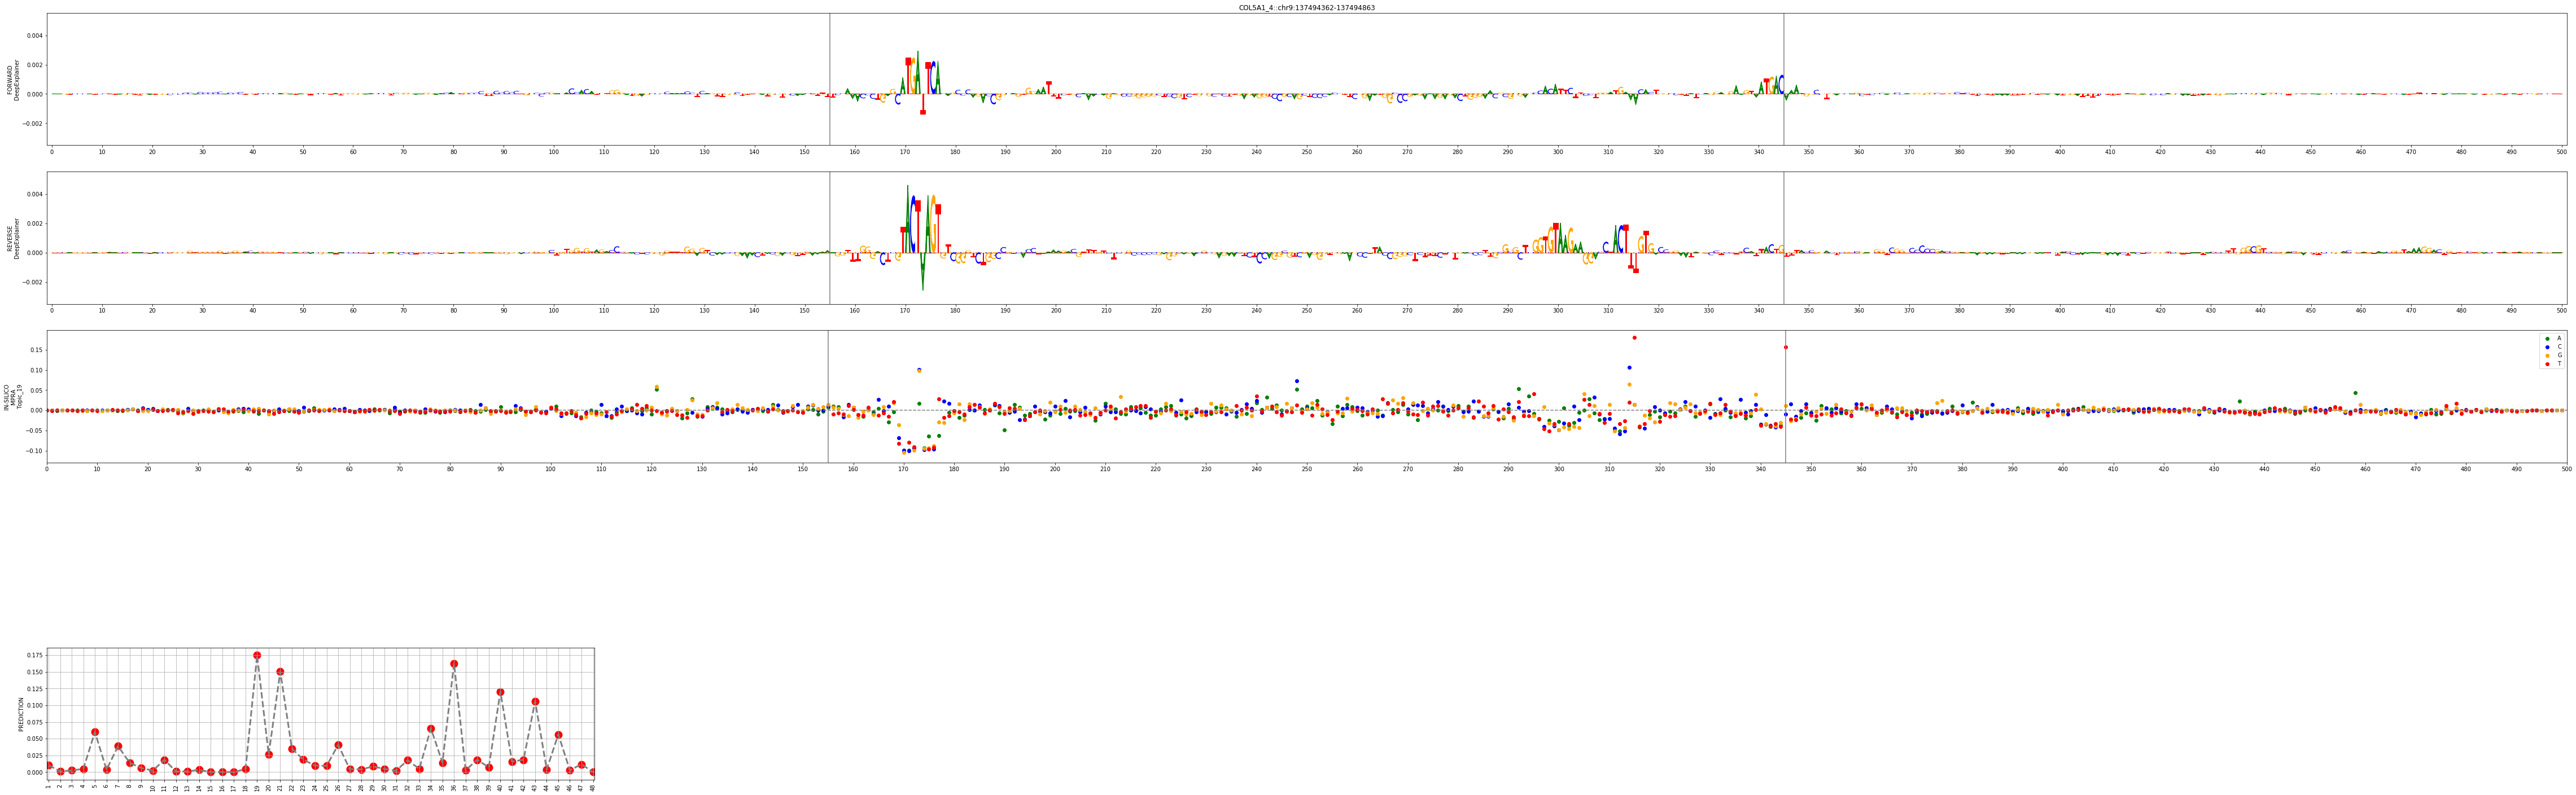

In [12]:
deepexplainer_plot(name="COL5A1_4::chr9:137494362-137494863", OLS="500", topic=19, model="deepmel2_gabpa")


Topic: 19


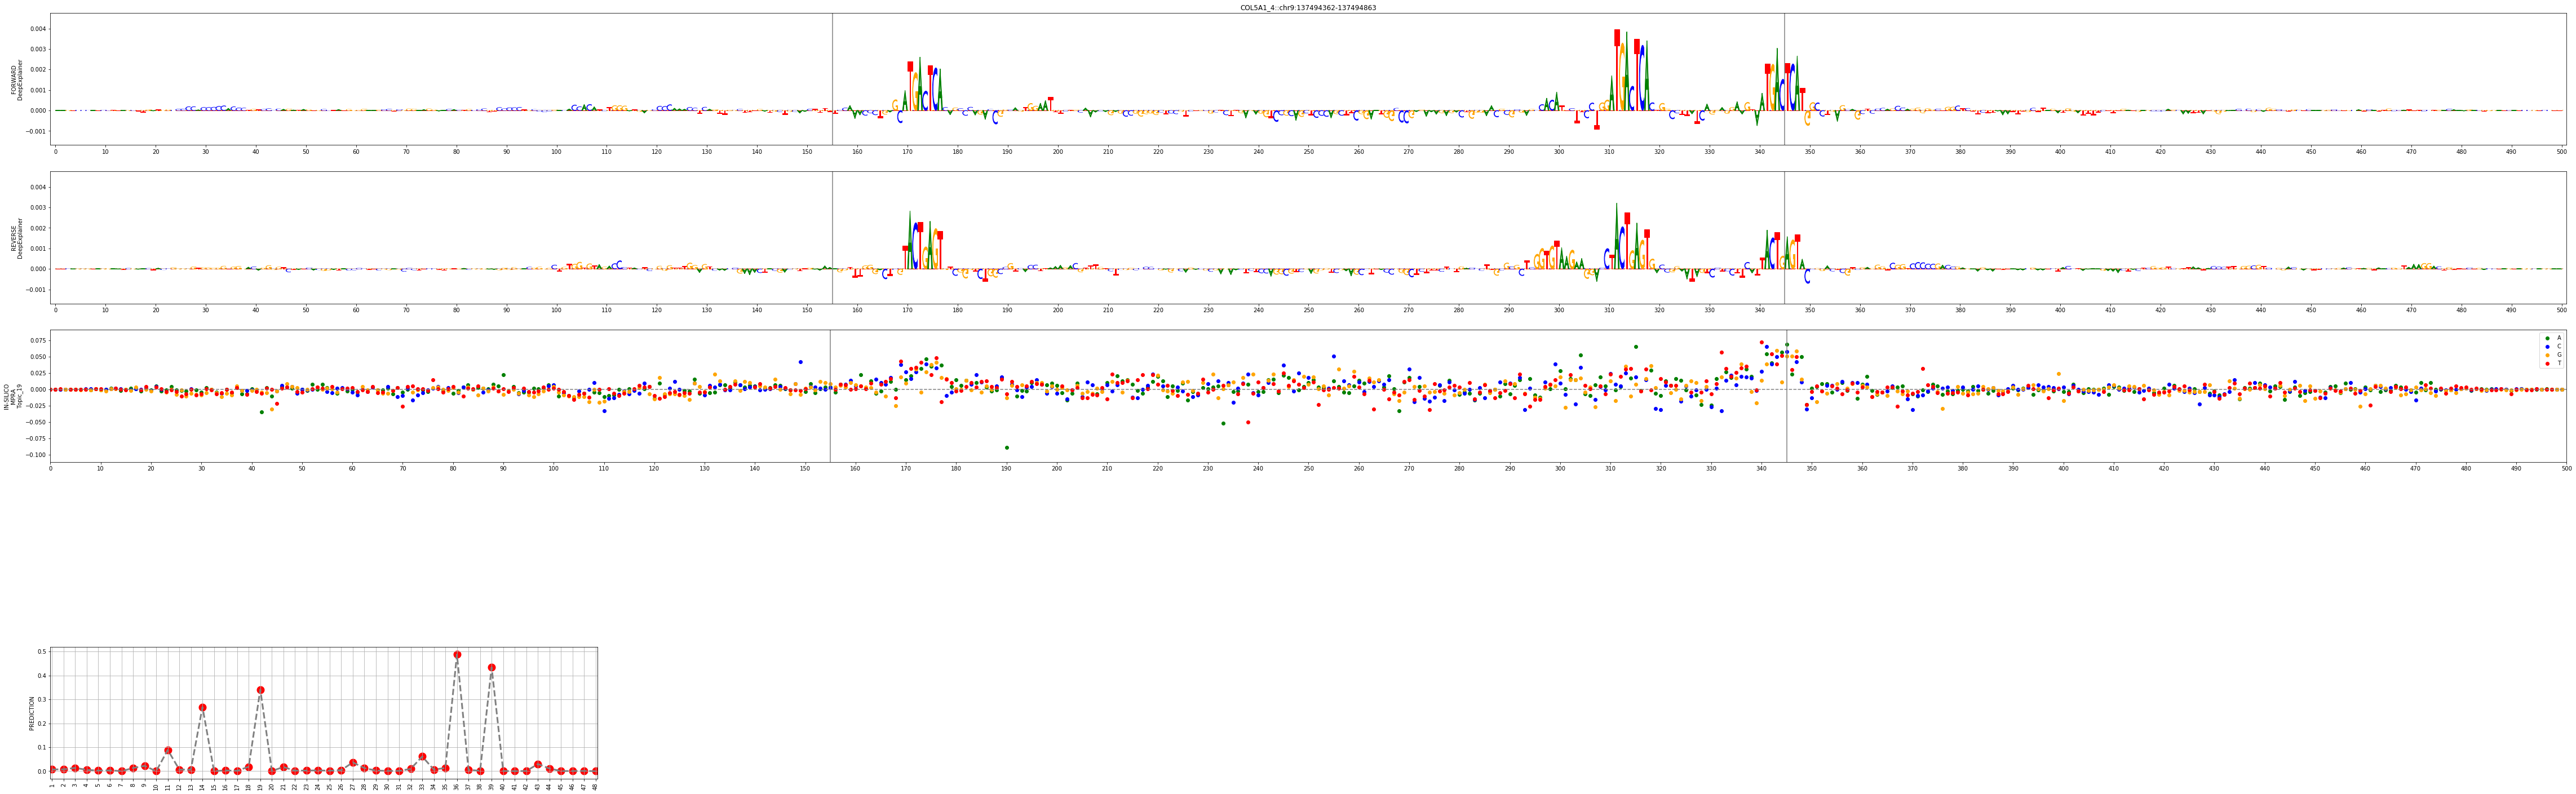

In [19]:
mutation_list = [[173,"C"],[255,"G"],[314,"C"],[315,"T"],[345,"T"],[346,"C"]]
deepexplainer_plot_with_mutation(name="COL5A1_4::chr9:137494362-137494863", OLS="500", topic=19, mutation_list=mutation_list, model="deepmel2_gabpa")

In [18]:
mutation_list = [[173,"C"],[255,"G"],[314,"C"],[315,"T"],[345,"T"],[346,"C"]]
deepexplainer_plot_with_mutation_onlyprediction(name="COL5A1_4::chr9:137494362-137494863", OLS="500", topic=19, mutation_list=mutation_list, model="deepmel2_gabpa")

Topic_19 0.34148738


# DeepMEL1 Explainer plots

In [ ]:
deepexplainer_plot(name="chr22:38434792-38434982@@SOX10_5==wt", OLS="A", topic=13, model="deepmel", save="False" )

# DeepMEL Explainer WT vs Mutant

In [6]:
deepexplainer_plot_wt_vs_mut(name="chr4:55708936-55709126@@KIT_1==wt",
                             dif_name="chr4:55708936-55709126@@KIT_1==mut homer__RTCATGTGAC_MITF chr4:55708939__G_A chr4:55708939__G_T", 
                             OLS="B", 
                             topic=17,
                             model="deepmel2_gabpa",
                             save="/staging/leuven/stg_00002/lcb/lcb_projects/CSE/analysis/OLS_A-B_DL_investigation/DeepExplainer_DeepMEL2_GABPA/") #/staging/leuven/stg_00002/lcb/lcb_projects/CSE/analysis/OLS_A-B_DL_investigation/DeepExplainer/

Topic: 17


In [ ]:
for id in OLS_dict["500"]["ids"]:
    deepexplainer_plot(name=id, OLS="500", topic=16, model="deepmel2_gabpa", save="/staging/leuven/stg_00002/lcb/lcb_projects/CSE/500bp_ATAC_peak_library/DeepExplainer_profiles/DeepMEL2_GABPA/" )

# Plot list of specific regions

In [3]:
names = np.array(["chr19:36236292-36236482@@Human_150","chr6:8814749-8814939@@Human_restTopic11_90","chr5:159886192-159886382@@Human_313","chr16:87887293-87887483@@Human_112","chr21:35917591-35917781@@Human_restTopic11_364","chr3:38369077-38369267@@Human_restTopic11_200","chr3:38369197-38369387@@Human_restTopic11_200","chr12:110517693-110517883@@Human_restTopic11_492","chr12:83092619-83092809@@Human_restTopic11_230","chr12:110517573-110517763@@Human_restTopic11_492"])

In [4]:
for id in names:
    deepexplainer_plot(name=id, OLS="Liesbeth_SOX10KD", topic=16, model="deepmel2_gabpa", save="/staging/leuven/stg_00002/lcb/lcb_projects/CSE/SOX10-KD_library/analysis/DeepExplainer/")

W0324 14:58:17.876927 46991365832320 deprecation.py:323] From /staging/leuven/stg_00002/lcb/itask/programs/anaconda3/envs/deeplearning/lib/python3.6/site-packages/shap/explainers/deep/deep_tf.py:461: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Topic: 16
Topic: 16
Topic: 16
Topic: 16
Topic: 16
Topic: 16
Topic: 16
Topic: 16
Topic: 16
Topic: 16


## Custom size plot with wt and mutant together (Combined forward and reverse values)

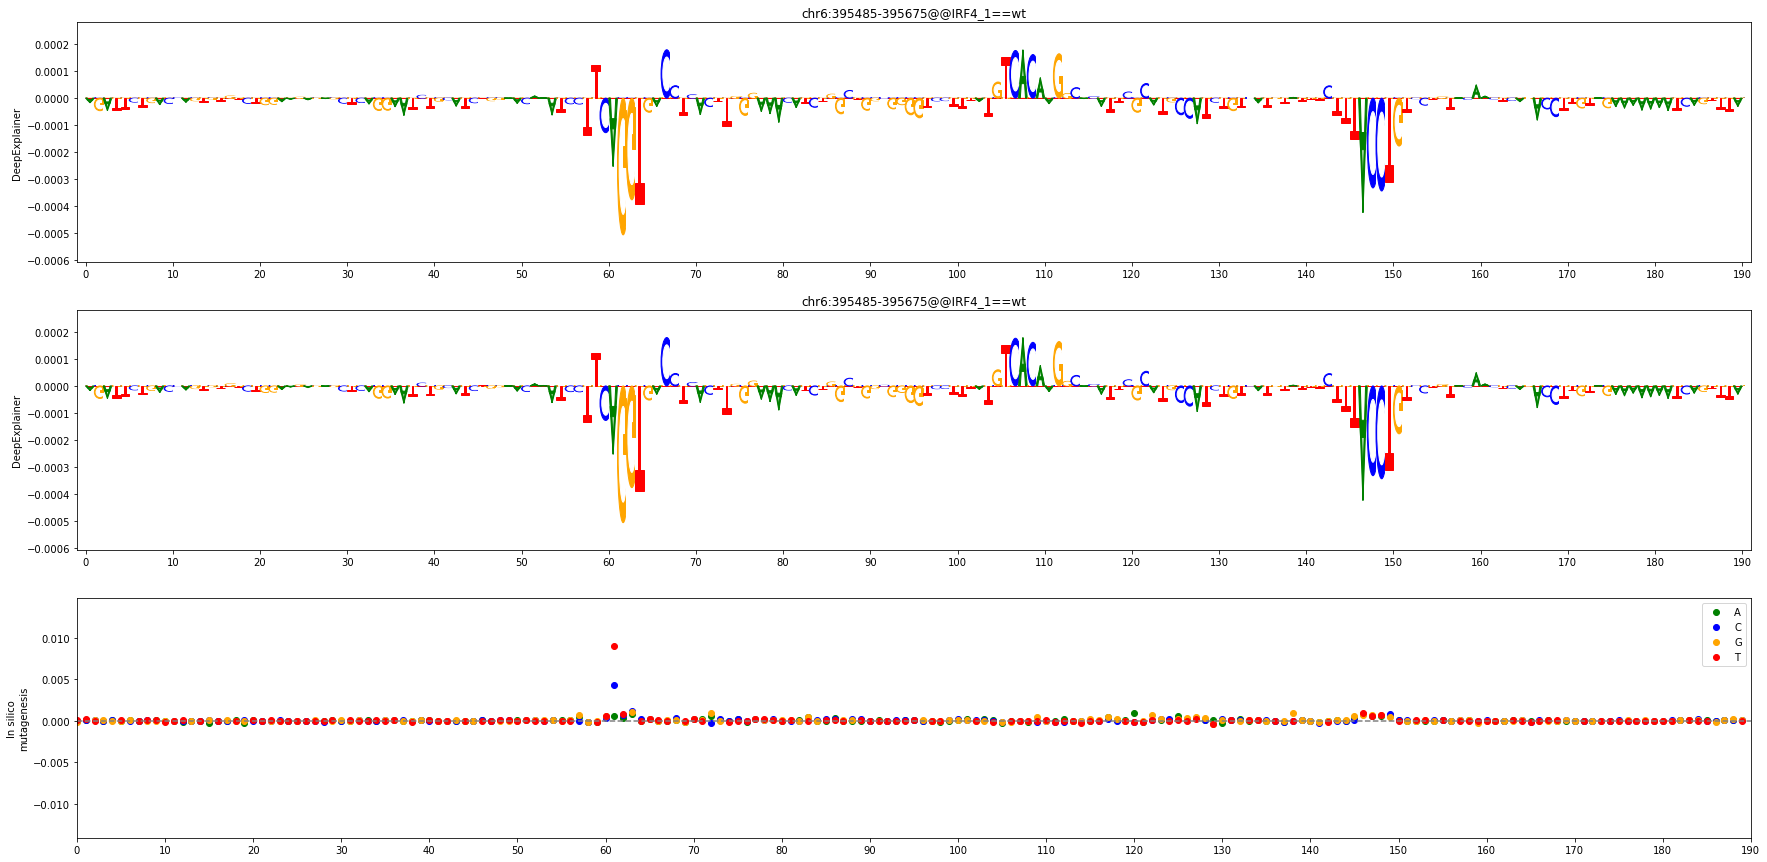

In [7]:
OLS = "A"
model = "deepmel2_gabpa"
topic=17
ntrack = 3
fig = plt.figure(figsize=(30,ntrack*5))
ax1 = plot_deepexplainer_givenax(name="chr6:395485-395675@@IRF4_1==wt", OLS=OLS, topic=topic, model=model,
                           fig=fig, ntrack=ntrack, trackno=1, st=155, end=345)
ax2 = plot_deepexplainer_givenax(name="chr6:395485-395675@@IRF4_1==wt", OLS=OLS, topic=topic, model=model,
                           fig=fig, ntrack=ntrack, trackno=2, st=155, end=345)
ax3 = plot_saturation_givenax(name="chr6:395485-395675@@IRF4_1==wt", OLS=OLS, topic=topic, model=model,
                           fig=fig, ntrack=ntrack, trackno=3, st=155, end=345)
ax1.set_ylim([np.min([ax1.get_ylim()[0],ax2.get_ylim()[0] ]) , np.max([ax1.get_ylim()[1],ax2.get_ylim()[1] ])])
ax2.set_ylim([np.min([ax1.get_ylim()[0],ax2.get_ylim()[0] ]) , np.max([ax1.get_ylim()[1],ax2.get_ylim()[1] ])])
plt.savefig("/staging/leuven/stg_00002/lcb/lcb_projects/CSE/analysis/OLS_A-B_DL_investigation/DeepExplainer_DeepMEL2_GABPA/OLS-A_topic17_chr6:395485-395675@@IRF4_1==wt.pdf",dpi=600,Transparent=True)
#plt.savefig(save+"OLS-"+OLS+"_topic"+str(indexes_[0][0]+1)+"_"+name__+"_vs_"+dif_name.split(" chr")[0]+".pdf",dpi=600,transparent=True)